In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers

from utils import show_dist, plot_hist_numerical, count_unique_values, show_group_stats_viz
from utils import create_tf_numeric_feature, enable_reproducibility, split_train_valid
from utils import df_to_dataset

sns.set()

import logging

%load_ext autoreload
%autoreload

In [2]:
# OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# to get reproducible results with TF training
# see in student_utils
enable_reproducibility(1234)

In [3]:
# global constant for training
BATCH_SIZE = 128
EPOCHS = 30

In [4]:
FILE = 'cs-training-nonull.csv'

orig_data = pd.read_csv(FILE)

In [5]:
# nomi di tutte le colonne
num_cols = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

cat_cols = ['isna_mi', 'isna_nod']

all_cols = num_cols + cat_cols

PREDICTOR_FIELD = 'SeriousDlqin2yrs'

In [6]:
# split in train, validation
# return tf dataset
ds_train, ds_valid = split_train_valid(orig_data, predictor_field=PREDICTOR_FIELD, batch_size=BATCH_SIZE)

Numero rec. per il training 120000
Numero rec. per validazione 30000


In [7]:
# to test
ds_batch = next(iter(ds_train))[0]

def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

In [8]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(df, c)

        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

# categorical columns
# for these we dpn't normalize
def create_tf_categorical_feature_cols(cat_col_list):
    tf_cat_col_list = []
    for c in cat_col_list:
        tf_cat_feature = tf.feature_column.numeric_column(c)
        tf_cat_col_list.append(tf_cat_feature)
    return tf_cat_col_list

In [9]:
tf_cont_col_list = create_tf_numerical_feature_cols(num_cols, orig_data)
tf_cat_col_list = create_tf_categorical_feature_cols(cat_cols)

# build the feature trasnformation layer (for now only continuous columns... need to add the last two columns)

tf_all_list = tf_cont_col_list + tf_cat_col_list
feature_layer = tf.keras.layers.DenseFeatures(tf_all_list, name='layer0')

In [10]:
# added to remove TF warnings !
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
        
def build_model(feature_layer, n_units):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(n_units, activation='relu', name='layer1'),
        tf.keras.layers.Dropout(0.1),
        # I prefer same number in the layers... the NN will decide
        tf.keras.layers.Dense(n_units, activation='relu', name='layer2'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid', name='layer5'),
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    
    return model

In [11]:
# non posso salvare in formato h5
def train_evaluate(ds_train, ds_valid, trial=1):
    model = build_model(feature_layer, n_units = 18)
    
    sv = tf.keras.callbacks.ModelCheckpoint('model_best', monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='min', save_freq='epoch')
    history = model.fit(ds_train, validation_data=ds_valid, epochs=EPOCHS, verbose=1, callbacks=[sv])
    
    auc = model.evaluate(ds_valid)
    
    return auc, history

In [12]:
auc, history = train_evaluate(ds_train, ds_valid, trial=1)

Epoch 1/30
938/938 [==============================] - 5s 4ms/step - loss: 0.3568 - auc: 0.5679 - val_loss: 0.2021 - val_auc: 0.8087

Epoch 00001: val_loss improved from inf to 0.20210, saving model to model_best
Epoch 2/30
938/938 [==============================] - 3s 3ms/step - loss: 0.2051 - auc: 0.7914 - val_loss: 0.1951 - val_auc: 0.8239

Epoch 00002: val_loss improved from 0.20210 to 0.19512, saving model to model_best
Epoch 3/30
938/938 [==============================] - 3s 3ms/step - loss: 0.1955 - auc: 0.8098 - val_loss: 0.1932 - val_auc: 0.8287

Epoch 00003: val_loss improved from 0.19512 to 0.19325, saving model to model_best
Epoch 4/30
938/938 [==============================] - 3s 3ms/step - loss: 0.1927 - auc: 0.8144 - val_loss: 0.1922 - val_auc: 0.8304

Epoch 00004: val_loss improved from 0.19325 to 0.19221, saving model to model_best
Epoch 5/30
938/938 [==============================] - 3s 3ms/step - loss: 0.1918 - auc: 0.8178 - val_loss: 0.1920 - val_auc: 0.8299

Epoch 0

In [13]:
def plot_loss(hist, skip):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['loss'][skip:], label='Training loss')
    plt.plot(hist.history['val_loss'][skip:], label='Validation loss')
    plt.title('Loss')
    plt.legend(loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.show();

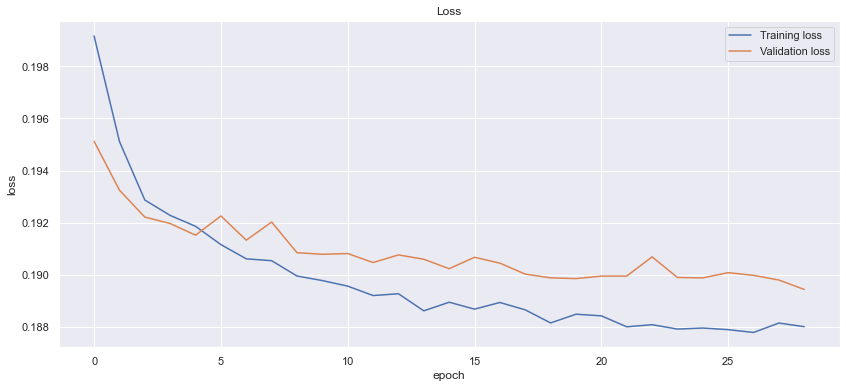

In [14]:
plot_loss(history, skip = 1)

In [15]:
def plot_auc(hist, skip):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['auc'][skip:], label='Training AUC')
    plt.plot(hist.history['val_auc'][skip:], label='Validation AUC')
    plt.title('AUC')
    plt.legend(loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.show();

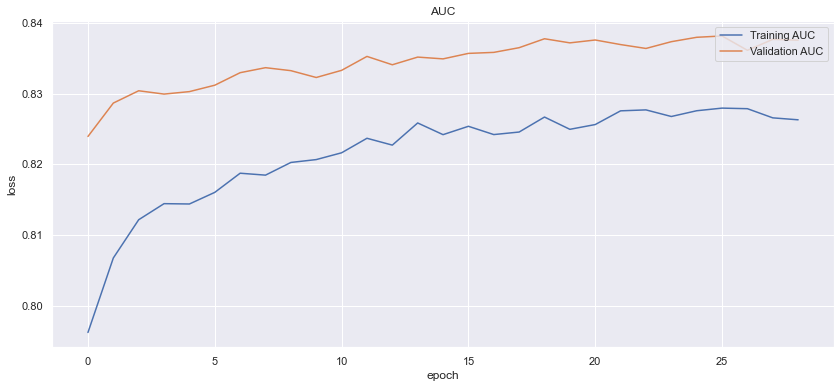

In [16]:
plot_auc(history, skip = 1)

In [19]:
# load best model
model = build_model(feature_layer, n_units = 18)

model.load_weights('model_best')

In [20]:
model.evaluate(ds_valid)

235/235 [==============================] - 1s 2ms/step - loss: 0.1930 - auc: 0.8375


[0.18942829966545105, 0.8375504612922668]

In [ ]:
# compute accuracy on validation set

THR = [0.40, 0.42, 0.44, 0.48, 0.50, 0.52, 0.54]

def compute_accuracy(thr):
    n_ok = 0.
    
    for features, labels in ds_valid:
        result = model.predict(features)
        
        condition = (result > thr)
        bin_result = tf.cast(condition, tf.int64)
        labels = tf.reshape(labels, bin_result.shape)
        
        n_ok += np.sum((bin_result == labels))
    
    acc = n_ok/len(df_valid)
    
    return acc

for tr in THR:
    tr_acc = compute_accuracy(tr)
    print('Threshold', tr, 'accuracy on validation set:', round(tr_acc, 3))

#### prediction on test set

In [21]:
orig_test = pd.read_csv('cs-test.csv')

orig_test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [22]:
orig_data = pd.read_csv('cs-training.csv')

df_stats = orig_data.describe().transpose()

In [23]:
mean_mi = df_stats.loc['MonthlyIncome', 'mean']
mean_nod = df_stats.loc['NumberOfDependents', 'mean']

In [24]:
condition = (orig_test['MonthlyIncome'].isna())

orig_test['isna_mi'] = 0

orig_test.loc[condition, 'isna_mi'] = 1
orig_test.loc[condition, 'MonthlyIncome'] = mean_mi

In [25]:
# inpute 

condition = (orig_test['NumberOfDependents'].isna())

orig_test['isna_nod'] = 0

orig_test.loc[condition, 'isna_nod'] = 1
orig_test.loc[condition, 'NumberOfDependents'] = mean_nod

In [26]:
# prepare ds
ds_test = df_to_dataset(orig_test, PREDICTOR_FIELD,  batch_size=512, shuffle=False)

In [40]:
all_probs = np.empty(shape=(0, 1))

for features, labels in ds_test:
    probs = model.predict(features)
    
    all_probs = np.append(all_probs, np.round(probs, 5))

In [41]:
all_probs = all_probs.reshape(all_probs.shape[0])

In [46]:
result_dict = {"Id": orig_test['Unnamed: 0'].values,
              'Probability': all_probs}

In [47]:
# salva il file della submission
FILE_SUB = 'submission7.csv'

result_df = pd.DataFrame(result_dict)

result_df.to_csv(FILE_SUB, index=False, float_format='%.5f')